In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import re

In [30]:
df = pd.read_csv('dataset.csv')

In [31]:
print(df.head())  # Display first few rows
print(df.info())  # Display dataset info (types, nulls, etc.)
print(df.describe())  # Summary statistics

  Corpus                                         Tweet Text  Stance Foundation
0    EVM  #EVMs are easy to manipulate . This was demons...       1   Fairness
1    CAA                    Congratulations\r\nAa gya  #CAA       1    Loyalty
2    CAA  My dear Indian muslims we are 35 crores of pop...      -1    Loyalty
3    CAA  This guy was part of anti Hindu protests in th...       1  Authority
4    CAA  Woman protester breaks down while speaking to ...       0       Care
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Corpus      274 non-null    object
 1   Tweet Text  274 non-null    object
 2   Stance      274 non-null    int64 
 3   Foundation  273 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.7+ KB
None
           Stance
count  274.000000
mean    -0.069343
std      0.837934
min     -1.000000
25%     -1.000000
50%      0.000000
7

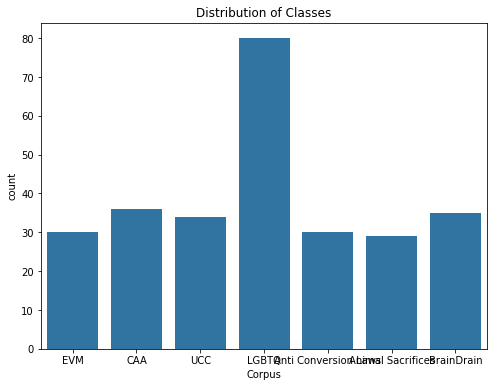

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Corpus....................................................................................................................................................................../-', data=df)
plt.title('Distribution of Classes')
plt.show()

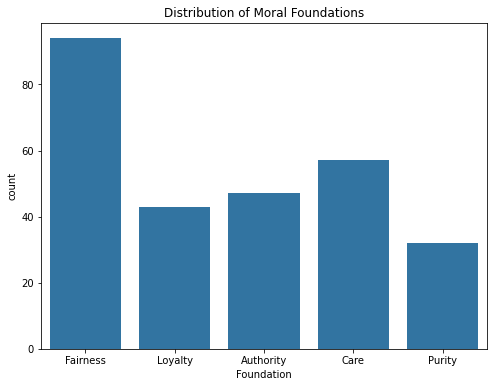

In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Foundation', data=df)
plt.title('Distribution of Moral Foundations')
plt.show()

In [35]:
def clean_tweet(tweet):
    tweet = re.sub(r'@[\w_]+', '', tweet)  # Remove @mentions
    tweet = re.sub(r'#\w+', '', tweet)     # Remove hashtags
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)  # Remove special characters
    tweet = tweet.strip().lower()  # Strip leading/trailing spaces and lowercase
    return tweet


In [38]:
df['cleaned_tweet'] = df['Tweet Text'].apply(clean_tweet)
#Preprocessing
df = df.dropna()  # Handle missing values

In [40]:
# Label encoding for 'class' and 'foundation' columns
le_class = LabelEncoder()
df['class_encoded'] = le_class.fit_transform(df['Corpus'])


C:\Users\User\AppData\Local\Temp\ipykernel_28124\46444361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class_encoded'] = le_class.fit_transform(df['Corpus'])


In [41]:
#TF-IDF Encoding
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_tweet']).toarray()

In [42]:
#BERT Encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [43]:
def get_bert_embeddings(texts):
    input_ids = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    with torch.no_grad():
        outputs = bert_model(**input_ids)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # [CLS] token embeddings
    return embeddings

In [44]:
X_bert = get_bert_embeddings(df['cleaned_tweet'].tolist())

In [45]:
# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bert, y_class, test_size=0.2, random_state=42)

In [46]:
#Train-Test Split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['class_encoded'], test_size=0.2, random_state=42)
X_train_bert, X_test_bert, _, _ = train_test_split(X_bert, df['class_encoded'], test_size=0.2, random_state=42)

In [47]:
# Step 9: Model Training and Testing with TF-IDF
svm_tfidf = SVC(kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train)
svm_tfidf_predictions = svm_tfidf.predict(X_test_tfidf)
print("SVM Accuracy with TF-IDF: ", accuracy_score(y_test, svm_tfidf_predictions))

SVM Accuracy with TF-IDF:  0.6


In [48]:
log_reg_tfidf = LogisticRegression(max_iter=1000)
log_reg_tfidf.fit(X_train_tfidf, y_train)
log_reg_tfidf_predictions = log_reg_tfidf.predict(X_test_tfidf)
print("Logistic Regression Accuracy with TF-IDF: ", accuracy_score(y_test, log_reg_tfidf_predictions))

Logistic Regression Accuracy with TF-IDF:  0.45454545454545453


In [49]:
# Step 10: Model Training and Testing with BERT
svm_bert = SVC(kernel='linear')
svm_bert.fit(X_train_bert, y_train)
svm_bert_predictions = svm_bert.predict(X_test_bert)
print("SVM Accuracy with BERT: ", accuracy_score(y_test, svm_bert_predictions))

SVM Accuracy with BERT:  0.7272727272727273


In [50]:
log_reg_bert = LogisticRegression(max_iter=1000)
log_reg_bert.fit(X_train_bert, y_train)
log_reg_bert_predictions = log_reg_bert.predict(X_test_bert)
print("Logistic Regression Accuracy with BERT: ", accuracy_score(y_test, log_reg_bert_predictions))

Logistic Regression Accuracy with BERT:  0.6727272727272727


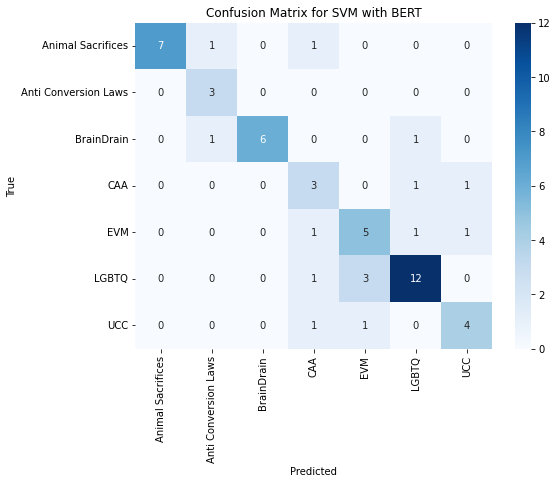

In [51]:
# Step 11: Model Evaluation
# Confusion Matrix for SVM with BERT
cm_bert = confusion_matrix(y_test, svm_bert_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=le_class.classes_, yticklabels=le_class.classes_)
plt.title('Confusion Matrix for SVM with BERT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

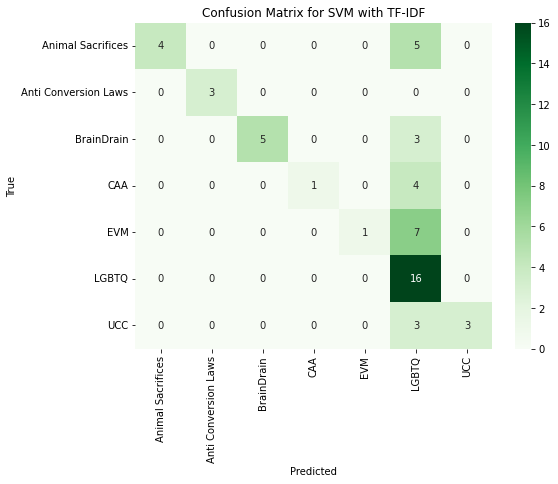

In [52]:
# Confusion Matrix for SVM with TF-IDF
cm_tfidf = confusion_matrix(y_test, svm_tfidf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens', xticklabels=le_class.classes_, yticklabels=le_class.classes_)
plt.title('Confusion Matrix for SVM with TF-IDF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [53]:
# Step 12: Cross-Validation
from sklearn.model_selection import cross_val_score

In [54]:
# Cross-validation for SVM with BERT
svm_bert_cv_scores = cross_val_score(svm_bert, X_bert, df['class_encoded'], cv=5)
print(f"SVM Cross-validation scores with BERT: {svm_bert_cv_scores}")

SVM Cross-validation scores with BERT: [0.65454545 0.72727273 0.70909091 0.83333333 0.7037037 ]


In [55]:
# Cross-validation for SVM with TF-IDF
svm_tfidf_cv_scores = cross_val_score(svm_tfidf, X_tfidf, df['class_encoded'], cv=5)
print(f"SVM Cross-validation scores with TF-IDF: {svm_tfidf_cv_scores}")

SVM Cross-validation scores with TF-IDF: [0.54545455 0.58181818 0.65454545 0.57407407 0.64814815]
